In [1]:
# Sarah loves music

from carabao.neurotron import Pulse,Terminal,Synapses,toy
from carabao.util import repr
from carabao.screen import Screen
from numpy import array

#===========================================================================
# class Moni
#===========================================================================

class Moni:
    def __init__(self,m,n):
        self.screen = Screen('Neurons',m,n)
    def __call__(self,cell,i,j):
        u = cell.u.out()
        y = cell.y;
        p = cell.p.out();
        d = cell.d.out();
        q = cell.q.out();
        self.screen.neurotron((i,j),u,q,p,y,d)
    def xlabel(self,x,txt,size=None):
        self.screen.text(x,-0.75,txt)

#===================================================================================
# class: Core
#===================================================================================

class Core:
    """
    class Core: implements a Neurotron core functionality
    >>> core = Core(k,excite,predict,depress,(10,3))
    """
    def __init__(self,k, e,d,p, name=""):
        self.k = k
        self.name = name

        self.excite  = Terminal(e.w[k],e.theta,'excite')
        self.depress = Terminal(d.w[k],d.theta,'depress')
        self.predict = Terminal(p.W[k],p.theta,'predict')

    def __call__(self,f,c,V,log=None):
        e = self.excite.empower(f)
        u = self.excite.spike(e)
        if log is not None: 
            print("   ",log,self.name,"e:",repr(e), "u:",u)

        v = self.depress.empower(c)
        d = self.depress.spike(v) 
        if log is not None: 
            print("   ",log,self.name,"v:",repr(v), "d:",d)

        E = self.predict.empower(V)
        s = self.predict.spike(E)
        if log is not None: 
            print("   ",log,self.name,"E:",repr(E), "s:",repr(s))

    def __repr__(self):
        return "Core('%s',%g"% (self.name,self.k) + ")"
        
#===================================================================================
# class: Neurotron
#===================================================================================

class Neurotron:
    """
    class Neurotron: full functionality
    >>> par = toy('sarah')
    >>> cell0 = Neurotron(k:=0,par,(10,3),'cell0')
    >>> print(cell0)
    """
    def __init__(self,k,par,sizes,name=None):
        self.k = k
        self.sizes = sizes
        self.name = name

        self.u = Pulse(1,1)
        self.q = Pulse(1,1)
        self.p = Pulse(3,5)
        self.d = Pulse(2,3)
        self.y = 0
        
        epar,dpar,ppar = par

        self.excite  = Terminal(epar.w[k],epar.theta,'excite')
        self.excite.synapses = Synapses(epar.k[k],epar.p[k],epar.eta)

        self.depress = Terminal(dpar.w[k],dpar.theta,'depress')
        self.depress.synapses = Synapses(dpar.g[k],dpar.p[k],dpar.eta)
    
        self.predict = Terminal(ppar.W[k],ppar.theta,'predict')
        self.predict.synapses = Synapses(ppar.K[k],ppar.P[k],ppar.eta)

    def __call__(self,y,log=None):
        nc,nf = self.sizes; k = self.k
        c = y[:nc];  f = y[nc:nc+nf]
        
        if log is not None:
           print("f:",f,", c:",c)
            
        u = self.excite(f,"=> excite-%g" % k)
        #print('************** u:',u)
        u = self.u(u,' - u%g:' % k)
        q = self.q(u,' - q%g:' % k)
        #print('************** q:',q)
        
        d = self.depress(c,"=> depress-%g" % k)
        self.d(d,' - d%g:' % k)
        
        self.s = self.predict(c,"=> predict-%g" % k)
        #b = self.s.max()

        p = self.p(0,' - p%g:' % k)

        self.y = (u * p or q * (1-d))*1
        print(" - y%g: %g*%g || %g*(not %g) ->" % (k,u,p,q,d),self.y) 
        y[k] = self.y
        if log is not None:
            print("y = [c,f]:",[y[:nc],y[nc:nc+nf]])
        return y

    def __repr__(self):
        #state = "), <updy> = <%g%g%g%g>" % (self.u,self.p,self.d,self.y)
        return "Neurotron('%s',%g"% (self.name,self.k) + ""

#===========================================================================
# class Cells
#===========================================================================

class Cells:
    def __init__(self,n,par,sizes):
        self.cells = []
        for k in range(n):
            cell = Neurotron(k,par,sizes)
            self.cells.append(cell)
        self.u = [[] for k in range(n)];  
        self.q = [[] for k in range(n)];  
        self.p = [[] for k in range(n)];  
        self.d = [[] for k in range(n)];  
        self.y = [[] for k in range(n)];  

    def __call__(self,y,log=None):
        if log is not None:
            print("\n"+log)
        for k in range(len(self.cells)):
            y = self.cells[k](y,log)

        for k in self.range():
            self.u[k].append(self[k].u.out())
            self.q[k].append(self[k].q.out())
            self.p[k].append(self[k].p.out())
            self.d[k].append(self[k].d.out())
            self.y[k].append(self[k].y)
        self.log(log)
        return y

    def __getitem__(self,k):
        return self.cells[k]

    def range(self):
        return range(len(self.cells))
        
    def plot(self,j,tag=''):   # plot cell column at monitor location (*,j)
        for k in range(len(self.cells)):
            mon(self.cells[k],k,j)
        mon.xlabel(j,tag)

    def log(self,tag=None):
        print('summary',tag)
        print("   u:",self.u)
        print("   q:",self.q)
        print("   p:",self.p)
        print("   d:",self.d)
        print("   y:",self.y)
        
#=========================================================================
# helper: concatenate two Neurotron output lists
#=========================================================================

def cat(c,f):
    """
    cat(): concatenate two Neurotron output lists, return also sizes
    >>> y,sizes = cat(c,f)
    """
    sizes = (len(c),len(f))
    return (c+f,sizes)



######### epar.w[0]: [1, 1, 0, 1, 1, 1, 0, 1, 0, 1]
######### epar.w[1]: [0, 1, 1, 1, 0, 1, 1, 0, 1, 1]
######### epar.w[2]: [1, 1, 1, 0, 0, 1, 0, 1, 1, 1]

iteration 0 (pattern)
f: [1, 1, 0, 1, 1, 1, 0, 1, 0, 1] , c: [0, 0, 0]
=> excite-0 [1 1 0 1 1 1 0 1 0 1] -> #[1 1 0 1 1 1 0 1 0 1] -> #[1 1 0 1 1 1 0 1 0 1] -> :[1]
 - u0:  1 -> ([1,0],0/1) -> 0
 - q0:  0 -> ([0,0],0/1) -> 0
=> depress-0 [0 0 0] -> #[1 1 1] -> #[0 0 0] -> :[0]
 - d0:  0 -> ([0,0,0],0/3) -> 0
=> predict-0 [0 0 0] -> #[1 0 0; 1 0 0] -> #[0 0 0; 0 0 0] -> :[0 0]
 - p0:  0 -> ([0,0,0,0],4/5) -> 1
 - y0: 0*1 || 0*(not 0) -> 0
y = [c,f]: [[0, 0, 0], [1, 1, 0, 1, 1, 1, 0, 1, 0, 1]]
f: [1, 1, 0, 1, 1, 1, 0, 1, 0, 1] , c: [0, 0, 0]
=> excite-1 [1 1 0 1 1 1 0 1 0 1] -> #[1 1 0 1 1 1 0 1 0 1] -> #[1 1 0 1 1 1 0 1 0 1] -> :[1]
 - u1:  1 -> ([1,0],0/1) -> 0
 - q1:  0 -> ([0,0],0/1) -> 0
=> depress-1 [0 0 0] -> #[1 1 1] -> #[0 0 0] -> :[0]
 - d1:  0 -> ([0,0,0],0/3) -> 0
=> predict-1 [0 0 0] -> #[1 0 0; 1 0 0] -> #[0 0 0; 0 0 0]

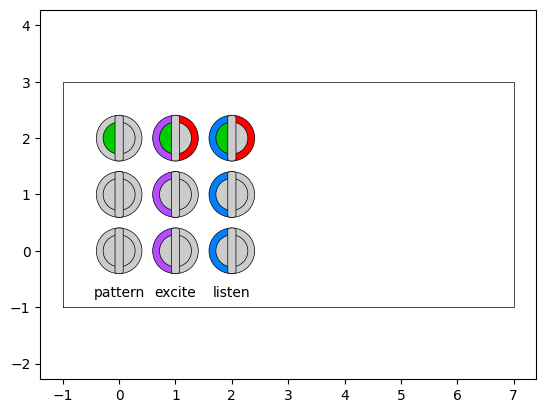

In [2]:
par,token = toy('sarah')
#par[0].w[2] = par[0].w[1] = par[0].w[0] # all the same
par[0].p[2] = par[0].p[1] = par[0].p[0] # all the same

y,sizes = cat(c:=[0,0,0],token['Sarah'])
cells = Cells(3,par,sizes)
cells[0].p.set(1)

mon = Moni(3,7)
y = cells(y,'iteration 0 (pattern)');  cells.plot(0,'pattern')
y = cells(y,'iteration 1 (excite)');   cells.plot(1,'excite')
y = cells(y,'iteration 2 (listen)');   cells.plot(2,'listen')

In [3]:
#=========================================================================
# Sarah Loves music
#=========================================================================

f = [1,1,0,1,1,1,0,1,0,1];  c = [1,1,1]; x = f+c
par,token = toy('sarah')
cell = Neurotron(0,par,(len(f),len(c)),'cell0') 

print(cell.excite)

E = cell.excite(token['Sarah'],"decode 'Sarah':")
E = cell.excite(token['loves'],"decode 'loves':")
E = cell.excite(token['music'],"decode 'music':")

# or broken down to the intermediate steps:

E = cell.excite.empower(token['Sarah'],"empower 'Sarah':")
s = cell.excite.spike(E,'         spike:')

E = cell.excite.empower(token['loves'],"empower 'loves':")
s = cell.excite.spike(E,'         spike:')


######### epar.w[0]: [1, 1, 0, 1, 1, 1, 0, 1, 0, 1]
Terminal('excite',#[1 1 0 1 1 1 0 1 0 1],6) @ {#[0 1 2 3 4 5 6 7 8 9], #[1 1 0 1 1 1 0 1 0 1] @ 0.5}
decode 'Sarah': [1 1 0 1 1 1 0 1 0 1] -> #[1 1 0 1 1 1 0 1 0 1] -> #[1 1 0 1 1 1 0 1 0 1] -> :[1]
decode 'loves': [0 1 1 1 0 1 1 0 1 1] -> #[1 1 0 1 1 1 0 1 0 1] -> #[0 1 0 1 0 1 0 0 0 1] -> :[0]
decode 'music': [1 1 1 0 0 1 0 1 1 1] -> #[1 1 0 1 1 1 0 1 0 1] -> #[1 1 0 0 0 1 0 1 0 1] -> :[0]
empower 'Sarah': [1 1 0 1 1 1 0 1 0 1] -> #[1 1 0 1 1 1 0 1 0 1]
         spike: #[1 1 0 1 1 1 0 1 0 1] -> :[1]
empower 'loves': [0 1 1 1 0 1 1 0 1 1] -> #[0 1 0 1 0 1 0 0 0 1]
         spike: #[0 1 0 1 0 1 0 0 0 1] -> :[0]


In [4]:
#=========================================================================
# iterations on top level
#=========================================================================

par,token = toy('sarah')
c = [1,1,1];  f = token['Sarah'];  
y,sizes = cat(c,f)
cell = [None,None,None]

cell[0] = Neurotron(0,par,sizes,'cell0') 
cell[1] = Neurotron(1,par,sizes,'cell1') 
cell[2] = Neurotron(2,par,sizes,'cell2') 

print("\nIteration 1: apply y := [1,1,1] + token['Sarah']")
y = cell[0](y,'apply')
y = cell[1](y,'apply')
y = cell[2](y,'apply')

print("\nIteration 2: apply y := [1,1,1] + token['Sarah']")
y = cell[0](y,'apply')
y

######### epar.w[0]: [1, 1, 0, 1, 1, 1, 0, 1, 0, 1]
######### epar.w[1]: [0, 1, 1, 1, 0, 1, 1, 0, 1, 1]
######### epar.w[2]: [1, 1, 1, 0, 0, 1, 0, 1, 1, 1]

Iteration 1: apply y := [1,1,1] + token['Sarah']
f: [1, 1, 0, 1, 1, 1, 0, 1, 0, 1] , c: [1, 1, 1]
=> excite-0 [1 1 0 1 1 1 0 1 0 1] -> #[1 1 0 1 1 1 0 1 0 1] -> #[1 1 0 1 1 1 0 1 0 1] -> :[1]
 - u0:  1 -> ([1,0],0/1) -> 0
 - q0:  0 -> ([0,0],0/1) -> 0
=> depress-0 [1 1 1] -> #[1 1 1] -> #[1 1 1] -> :[1]
 - d0:  1 -> ([1,0,0],0/3) -> 0
=> predict-0 [1 1 1] -> #[1 0 0; 1 0 0] -> #[1 0 0; 1 0 0] -> :[0 0]
 - p0:  0 -> ([0,0,0,0],0/5) -> 0
 - y0: 0*0 || 0*(not 1) -> 0
y = [c,f]: [[0, 1, 1], [1, 1, 0, 1, 1, 1, 0, 1, 0, 1]]
f: [1, 1, 0, 1, 1, 1, 0, 1, 0, 1] , c: [0, 1, 1]
=> excite-1 [1 1 0 1 1 1 0 1 0 1] -> #[0 1 1 1 0 1 1 0 1 1] -> #[0 1 0 1 0 1 0 0 0 1] -> :[0]
 - u1:  0 -> ([0,0],0/1) -> 0
 - q1:  0 -> ([0,0],0/1) -> 0
=> depress-1 [0 1 1] -> #[1 1 1] -> #[0 1 1] -> :[1]
 - d1:  1 -> ([1,0,0],0/3) -> 0
=> predict-1 [0 1 1] -> #[1 0 0

[0, 0, 0, 1, 1, 0, 1, 1, 1, 0, 1, 0, 1]